# INF8775 – Analyse et conception d’algorithmes
# TP2 – Automne 2025

LI, Bai Wu, 2179304

LIM, Guek Lang, 2119882

Note finale :

 <u>**Date limite de remise :**</u>  11 novembre 23h59 (Groupe B1), 4 novembre 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.  Cela s'applique aussi au niveau de l'IA générative pour le code. Par contre, vous devez être capable d'accomplir les analyses par vous-même. Vous ne pouvez pas utiliser l'IA pour ces sections.
## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l'analyse et la conception d'algorithmes développés suivant différents patrons de conception afin de résoudre une version simplifiée d'un problème réaliste d'optimisation.


## Description du problème

Un pianiste souhaite jouer une mélodie donnée par une partition. La mélodie est une suite de n notes *(a0, a1, ... , an-1)* où chaque ai appartient à un ensemble de m notes numérotées de 0 à m-1.

Le pianiste peut choisir de jouer chaque note avec l’un de ses D doigts. Le passage de la note i1 jouée avec le doigt d1 à la note i2 jouée avec le doigt d2 est pénalisée par une fonction de difficulté de la transition *C(i1, d1, i2, d2)*. Notre pianiste souhaite donc déterminer avec quel doigt il doit jouer chaque note de la mélodie de façon à minimiser la somme des coûts de chaque transition.

Pour la partie empirique de ce TP, nous nous limiterons à des mélodies jouées à une main (D=5) sur deux octaves (m=24).

Soit l’exemple suivant avec 5 notes :

- L'exemplaire est : `[17, 21, 18, 2, 21, 15, 11, 16]`
- La solution est : `[2, 1, 1, 0, 1, 1, 2, 1]`

La figure ci-dessous représente la partition avec ça solution et le coût associé à chaque transition.

![alt text](example_solution.png "Title")

## Algorithmes à implanter

Trois algorithmes seront implantés, mettant en pratique des patrons de conception différents :

1. Un algorithme glouton
2. Un algorithme de programmation dynamique
3. Un algorithme de recherche locale


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress
import time
from collections.abc import Callable

In [2]:
def visualize_solution(costs, partition, solution):
    """
    Visualisez votre solution et les coûts associés.
    """
    # Create a figure and axis
    _, ax = plt.subplots()

    # Plot the notes as circles with their sizes proportional to the partition values
    for i in range(len(partition)):
        ax.scatter([i], [partition[i]], marker='o')
        ax.text(i, partition[i] + 0.2, str(solution[i]), ha='center', va='bottom')

    # Set the limits for the axes to fit the plot
    ax.set_ylim(min(partition) - 1, max(partition) + 1)
    ax.set_xlim(-0.5, len(partition)-0.5)

    # Label the axes
    ax.set_xlabel('Partition')
    ax.set_ylabel('Note')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Title the plot
    ax.set_title('Partition et doigts utilisés')

    plot_costs = getCosts(costs, partition, solution).tolist()
    plot_costs.append(0)

    ax2 = ax.twinx()
    ax2.bar(range(len(partition)), plot_costs, width=1, alpha=0.5, align='edge', color='gray')
    ax2.set_xlim(-0.5, len(partition)-0.5)
    ax2.set_ylim(0, 100)

    # Remove the ticks and tick labels from the secondary y-axis
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.set_yticklabels([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # Show the plot
    plt.show()

def generate_sample(size, maxValue=24):
    return np.random.randint(0, maxValue, size).tolist()

def get_dataset(seed, sizes, nbSamples=5):
    np.random.seed(seed)
    return { size: [generate_sample(size) for _ in range(nbSamples)]
        for size in sizes }

def readFile(filePath):
    """
    Charger une partition depuis un fichier
    """
    f = open(filePath)
    N = int(f.readline())
    partition = list(map(int, f.readline().split(' ')))
    f.close()
    return partition

def getCosts(costs, partition, solution):
    """
    Liste des coûts associés à chaque transition de votre solution.
    """
    prevNotes, nextNotes = partition[:-1], partition[1:]
    prevFingers, nextFingers = solution[:-1], solution[1:]
    return costs[prevNotes, prevFingers, nextNotes, nextFingers]

def getTotalCost(costs, partition, solution):
    """
    Coût total de votre solution
    """
    return np.sum(getCosts(costs, partition, solution))

Exécutez la cellule suivante afin d'obtenir le tenseur des coûts associé à chaque transition.

In [3]:
load_file = np.loadtxt('cout_transition.txt', dtype=int)
costs = load_file.reshape((24, 5, 24, 5))
D = 5    # Nombre de doigts
M = 24   # Etendue des notes (2 octaves)

partition = readFile('Chansons/twinkle_twinkle.txt')
dataset = get_dataset(seed=2179304, sizes=[n * 1000 for n in range(1, 100, 5)])

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [4]:
class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, mean: int, score:int) -> None:
        self.size = size
        self.mean_score = score
        self.mean = mean

def is_valid_solution(original: list[int], solution: list[int]) -> bool:
    """Validates solution"""

    n = len(original)

    if len(solution)!=n:
      return False

    for i in range(n):
        if solution[i]<0 or solution[i]>=D:
            return False

    # Solution is valid
    return True

def measure(procedure: Callable, sample: list[int], costs,  time_scale: int) -> int:
    """Returns the time in milliseconds taken to run the procedure.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample)
    end: int = time.time() * time_scale
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    score = getTotalCost(costs,sample, solution)
    return (round(end - start), score)

def measure_mean(procedure: Callable, samples: list[list[int]],size: int, costs , time_scale: int) -> Measure:
    """Generates multiple samples with the specified parameters and returns the mean time in milliseconds

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    results=[measure(procedure,sample,costs,time_scale) for sample in samples]
    mean_time = sum(
        [result[0] for result in results]
    ) / len(samples)
    mean_score = sum(
        [result[1] for result in results]
    ) / len(samples)
    return Measure(size, mean_time, mean_score)

def measure_procedure(procedure: Callable, dataset: list[list[list[int]]], costs,  time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken in milliseconds for each size in the given list.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.

    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time.
    """
    return [
        measure_mean(procedure, samples, size, costs , time_scale)
        for size,samples in dataset.items()
    ]



def display_measures_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <16} {: <16} {: <16}".format("Taille", "Temps moyen", "Score moyen"))
    for measure in measures:
        print("{: <16} {: <16} {: <16}".format(measure.size, measure.mean, measure.mean_score))

def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)
    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Partie 1 : Algorithme glouton (6 points)

Implantez un algorithme suivant le patron de conception glouton.

L'algorithme glouton fait son choix en fonction du coût de la prochaine transition :

Les deux premiers doigts d0 et d1 sont choisis de façon à minimiser C(a0, d0, a1, d1). Puis, étant donné le
doigt précédent d et la transition de la note i vers la note j, le choix glouton porte sur le doigt d’ qui
minimise C(i, d, j, d’).

Tentez de rendre votre implantation la plus performante possible en évitant des calculs inutiles.

Coût Glouton : 143


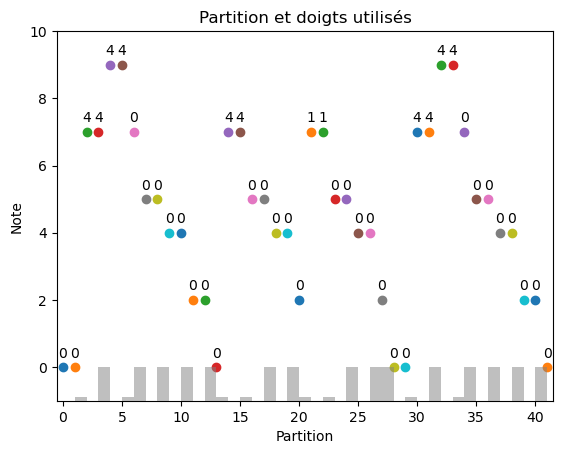

In [ ]:
def glouton(partition):
    solution = []
    
    min_cost = float('inf')
    for i in range(D):
        for j in range(D):
            cost = costs[partition[0], i, partition[1], j]
            if cost < min_cost:
                min_cost = cost
                solution = [i, j]

    for i in range(2, len(partition)):
        solution.append(np.argmin(costs[partition[i-1], solution[i-1], partition[i], :]))
        
    return solution

solutionGlouton = glouton(partition)
print("Coût Glouton :", getTotalCost(costs, partition, solutionGlouton))
visualize_solution(costs, partition, solutionGlouton)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

*Insérer votre réponse ici*
>Soit $n$, la longueur de la mélodie (en nombre de notes) et $D$, le nombre de doigts utilisés.<br>
Selon l'énoncé, D est une constante dont la valeur est de 5 ($D=5$).<br>

>Analysons l'algorithme glouton étape par étape :
>1. On commence par initialiser une liste vide (solution), puis on effectue une affectation pour le coût minimum (min_cost). Ces 2 opérations élémentaires sont effectués en $\in\Theta(1)$.
>2. On tente de déterminer le point de départ (meilleurs doigts) pour les 2 premières notes de la mélodie via une boucle imbriquée. Les deux boucles itèrent chacune de 0 à D-1 pour une complexité de $\in\Theta(D^2)$.
>3. Dans la dernière boucle, on parcourt le reste de la partition en essayant chaque doigt pour trouver le coût de transition minimal. On itère sur $(n-2)$ notes pour choisir entre $D$ doigts possibles. Pour une complexité de $\in\Theta(nD)$.

>En additionnant les différentes parties de l'algorithme glouton, nous obtenons $\Theta(D^2+Dn)$.<br>
En utilisant, la règle du maximum vue en classe qui stipule que $\Theta(f+g)=\Theta(max(f,g))$ et sachant que $D$ est une constante, on peut conclure que le temps d'exécution est de $T(n)\in\Theta(n)$.  

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [6]:
measures_glouton = measure_procedure(glouton, dataset, costs)
display_measures_table(measures_glouton)

Taille           Temps moyen      Score moyen     
1000             1.6              14366.4         
6000             8.8              90340.4         
11000            15.8             165336.0        
16000            21.4             240819.6        
21000            29.2             312677.6        
26000            34.0             388039.8        
31000            48.0             462400.0        
36000            58.0             534780.4        
41000            65.6             612837.0        
46000            64.4             681578.2        
51000            81.2             760407.2        
56000            85.6             835520.4        
61000            83.2             907754.2        
66000            95.0             984008.2        
71000            95.0             1061722.2       
76000            105.6            1135770.0       
81000            121.4            1208015.2       
86000            121.4            1277765.0       
91000            125.6         

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

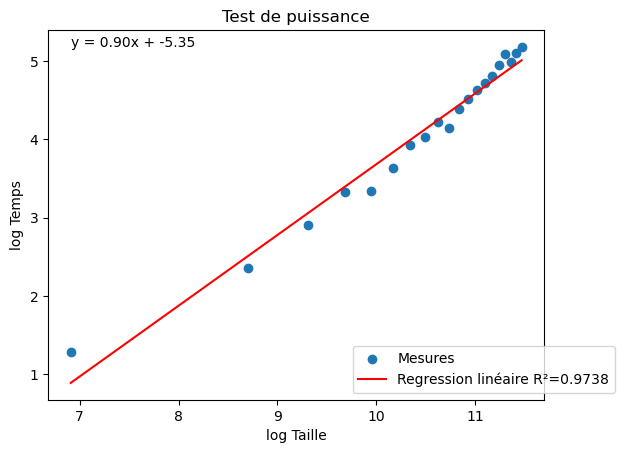

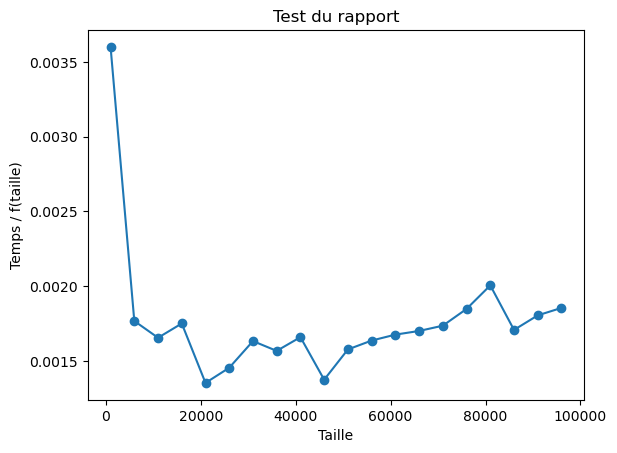

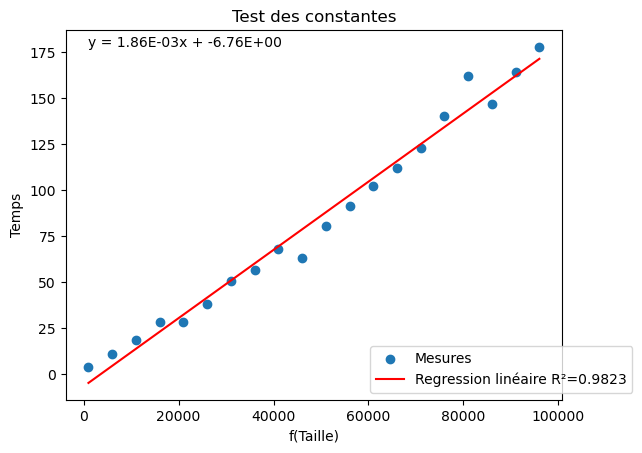

In [7]:
import math

def values_test_puissance(measures):
    return {
        math.log(measure.size): math.log(measure.mean)
        for measure in measures
    }

def values_test_rapport(measures, f):
    return {
        measure.size: measure.mean / f(measure.size)
        for measure in measures
    }

def values_test_constantes(measures, f):
    return {
        f(measure.size): measure.mean
        for measure in measures
    }

def f(x):
    return x

display_test_puissance(values_test_puissance(measures_glouton))
display_test_rapport(values_test_rapport(measures_glouton, f))
display_test_constantes(values_test_constantes(measures_glouton, f))

*Insérer votre réponse ici*
> La taille des exemplaires testés ($n$) varie entre 1000 et 96 000. Nous considérons cet ensemble assez varié dans le cadre du cours.<br>
L'hypothèse de départ (obtenue plus tôt via l'analyse asymptotique) est la suivante : le temps d'exécution $T(n) \in \Theta(n)$. <br>
Le but est de confirmer/précisier l'analyse asymptotique de l'algo glouton avec les méthodes hybrides vu en classe. Pour cela, nous allons utiliser les trois méthodes suivantes : le test de puissance, le test du rapport et le test des constantes.

> Soit $x$ : la taille d'un exemplaire et $y$ : le temps d'exécution de l'algorithme.<br><br>
> **1. <u>Test de puissance</u>**<br>
> - Le test de puissance permet de déterminer le taux de croissance de l'algorithme. Elle est obtenue en plaçant les couples $(x,y)$ sur une échelle log-log. Puis, via une droite de régression, on peut déterminer d'il s'agit d'une croissance polynomiale, super-polynomiale ou sub-linéaire.<br>
> - En observant le graphe 1, nous remarquons que la plupart des points s'alignent sur la droite de régression (en rouge), surtout au fur et à mesure que la taille des exemplaires augmente. Le coefficient de détermination ($R^2$) de 0.9738 nous indique une très forte corrélation linéaire, ce qui vient appuyer nos observations.
> - Comme on a une corrélation linéaire, le taux de croissance est polynomial dont le degré est donné par la pente. Cette dernière est de 0.90 qu'on peut approximé à 1. Ainsi, le taux de croissance de l'algorithme glouton est en $O(n)$. Cela appuie notre hypothèse (analyse asymptotique) effectuée précédement où $T(n)\in\Theta(n)$.

> **2. <u>Test du rapport</u>**<br>
> - Le test du rapport permet de valider l'hypothèse selon laquelle la fonction $f(x)$ représente le taux de croissance de l'algorithme.<br> Le graphe est obtenu en plaçant les points $(x, y/f(x))$ sur une échelle normale (linéaire).
> - Durant l'analyse asymptotique, nous avons déterminé que le temps d'exécution de l'algorithme glouton est $T(n)\in\Theta(n)$. C'est l'hypothèse que nous souhaitons vérifier avec le test du rapport, pour cette raison, nous posons $f(x)=x$.<br>
> - En observant le graphe 2, nous constatons qu'il y a une forte fluctuation entre les deux premiers exemplaires ($n=1000$ et $n=6000$). Comme il s'agit aussi des deux plus petits exemplaires, on peut poser comme hypothèse que le bruit y est plus grand. Puis, au fur et à mesure que la taille de l'exemplaire augmente, les points se stabilisent pour fluctuer entre 0.0015 et 0.0020. Ce qui laisse supposer que, lorsque la taille de l'exemplaire tend vers l'infini, la courbe aura tendance à converger vers une valeur constante d'environ 0.0018 (valeur approximée via observation du graphe). <br>
Selon les notes de cours, si la courbe converge vers une constante b et que cette dernière est $>0$ alors notre hypothèse est validée et b est la constante multiplicative de $f(x)$.
> - Donc, la fonction pour le taux de croissance serait $f(x) = 0.0018x$ et temps d'exécution de l'algo croît selon l'ordre exact de $\Theta(n)$.<br>

> **3. <u>Test des constantes</u>**<br> 
> - Le test des constantes permet de préciser la fonction associée au taux de croissance ($f(x)$).<br> Le graphe est obtenu en plaçant les couples $(f(x), y)$ sur une échelle normale.<br> Notre hypothèse est que le temps d'exécution de l'algo glouton $T(n)\in\Theta(n)$. Nous posons la fonction $f(x)=x$.<br> 
> - En observant le graphe 3, nous constatons que la majorité des points s'alignent avec la droite de régression. Le coefficient de corrélation de 0.9823 (forte corrélation) vient appuyer notre constat.<br>
> - Selon les notes de cours, s'il est possible de faire passer une droite à travers le nuage de points, alors :
>   - La pente de la droite représente la valeur moyenne de la constante multiplicative pour des exemplaires dont la taille tend vers infini. Ici, cette constante multiplicative est de $1,86\cdot10^{-3}$.<br>
>   - L'ordonnée à l'origine correspond au coût fixe. Ce coût est de $-6,76$ dans notre cas.

> **<u>Conclusion</u>**<br>
En conclusion, voici ce que nous apprennent ces 3 tests :
> - La complexité du temps d'exécution de l'algo gouton est linéaire : $T(n)\in\Theta(n)$.
> - Dans le test du rapport, nous avons estimé la constante multiplicative pour la fonction représentant le taux de croissance à 0.0018 : $f(x) = 0.0018x$. Le test des constantes vient renforcer cette hypothèse avec une constante multiplicative de 0.00186 (ce qui concorde avec ce qu'on avait trouvé précédemment).

## Partie 2 : Algorithme de programmation dynamique (6 points)

L'algorithme de programmation dynamique remplit un tableau des coûts de transition optimaux en
fonction de la mélodie.

Notons `J(k, d)` la somme minimale des coût de transition associée à la mélodie `(ak, ... , an−1)` (c’est-à-
dire au suffixe de longueur `n - k` de la mélodie de départ) où l’on joue la première note ak avec le doigt
d.

Alors, J vérifie la relation de récurrence (1) :

J(k, d) = min { 0≤ d’ ≤ D-1} [ C(ak, d, ak+1, d’ ) + J(k + 1, d’ ) ]

et la condition terminale (2) :

J(n - 1, d) = 0, ∀d = 0, ... , D - 1

Comme on ne connaît pas le premier doigt à utiliser a priori, la solution au problème original est
donnée par (3) :

min { 0 ≤ d ≤ D-1} J(0, d)

Cette récurrence est résolue par programmation dynamique pour déterminer la solution au problème.
Note : Pour vous aider à vérifier que votre implantation fonctionne correctement, voici deux solutions
que vous devriez obtenir avec cet algorithme (dépendant de votre implantation, il pourrait être possible
que vous arriviez au même coût, mais avec une différente suite de doigts) :

- twinkle_twinkle.txt ; coût = 31; doigts = [0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0, 4, 4, 3, 3, 2, 2, 0, 4, 4, 3,
3, 2, 2, 1, 0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0]

- fur_elise.txt ; coût = 1091; doigts = [1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4,
4, 0, 1, 4, 4, 0, 4, 3, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0,4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0,
1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4,
4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 4, 4, 4, 3,
2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 3, 3, 4, 3, 4, 0, 1, 2, 0, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1,
0, 4, 3, 1, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4,
4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4]

Implantez l'algorithme de programmation dynamique.

Coût Programmation Dynamique : 31


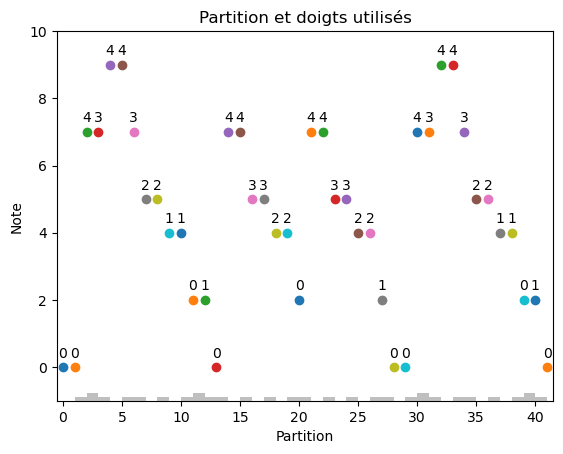

In [21]:
def progDyn(partition):
    n = len(partition)
    DP = np.zeros((n, D))
    solutions = np.zeros((n, D), dtype=int)

    for k in range(n-2, -1, -1):
        for d in range(D):
            d_min = np.argmin(costs[partition[k], d, partition[k+1], :] + DP[k+1, :])
            DP[k, d] = costs[partition[k], d, partition[k+1], d_min] + DP[k+1, d_min]
            solutions[k, d] = d_min

    solution = [0 for i in range(len(partition))]

    solution[0] = np.argmin(DP[0, :])
    for i in range(1, n):
        solution[i] = solutions[i-1, solution[i-1]]

    return solution

solutionDyn = progDyn(partition)
print("Coût Programmation Dynamique :", getTotalCost(costs, partition, solutionDyn))
visualize_solution(costs, partition, solutionDyn)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

*Insérer votre réponse ici*
>Soit $n$, la longueur de la mélodie et $D$, le nombre de doigts utilisés où $D=5$ selon l'énoncé du problème.<br>

>Effectuons l'analyse asymptotique de l'algorithme de programmation dynamique étape par étape :
>1. Tout d'abord, on initialise deux tableaux 2D (DP et solutions) de taille $n \times D$ (rangées x colonnes). Ces opérations se font en $\Theta(Dn)$.
>2. La boucle imbriquée calcule, à partir de l'avant dernière note (n-2), le coût minimal des transitions. La boucle externe parcourt les notes de la partition de la fin au début, donc approximativement n itérations. Chaque note k est parcouru D fois (on essaie chaque doigt possible) et pour chaque doigt d, on essait les D transitions vers les suivants. Ce qui donne une complexité de $\Theta(D^2n)$.
>3. On crée une liste `solution` qu'on remplit temporairement avec des 0, cela se fait en $\Theta(n)$.<br>
Puis, on choisit le meilleur doigt avec lequel jouer la première note, cela se fait en $\Theta(D)$.<br>
On remplit la liste `solution` en accèdant aux valeurs calculées dans le tableau `solutions`, cela se fait en $\Theta(n)$. La complexité pour ces étapes est de $\Theta(n+D+n)$, qu'on peut simplifier en $\Theta(n)$ en utilisant la règle du maximum.

>En additionnant les différentes parties de l'algorithme de programmation dynamique, nous obtenons $\Theta(Dn+D^2n+n)$.<br>
En utilisant, la règle du maximum vue en classe qui stipule que $\Theta(f+g)=\Theta(max(f,g))$ et sachant que $D$ est une constante, on peut conclure que le temps d'exécution est de $T(n)\in\Theta(n)$.  

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [9]:
measures_dyn = measure_procedure(progDyn, dataset, costs)
display_measures_table(measures_dyn)

Taille           Temps moyen      Score moyen     
1000             33.2             7540.0          
6000             189.4            46804.8         
11000            338.0            85156.6         
16000            496.6            123126.8        
21000            651.4            161437.2        
26000            792.8            198629.2        
31000            907.8            237095.6        
36000            1113.8           275354.2        
41000            1247.4           314031.4        
46000            1442.6           349879.2        
51000            1599.6           390226.6        
56000            1743.0           428908.6        
61000            1932.4           464725.0        
66000            2140.0           505492.2        
71000            2278.8           545042.6        
76000            2374.8           581907.4        
81000            2391.0           618149.4        
86000            2579.0           657238.4        
91000            2608.0        

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

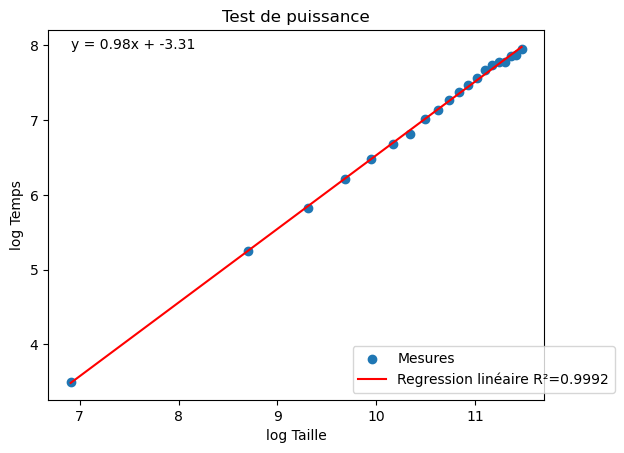

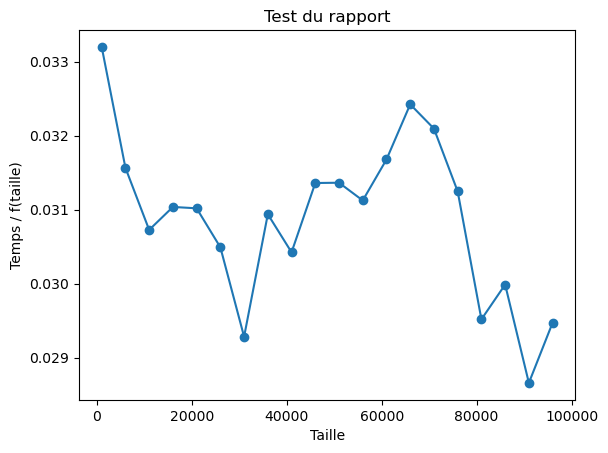

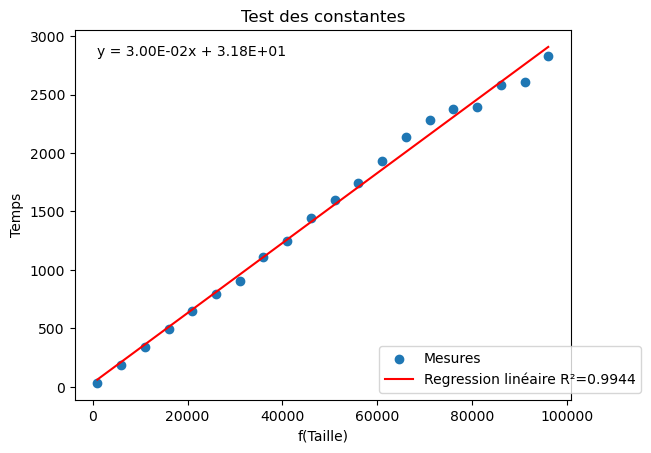

In [22]:
def f(x):
    return x

display_test_puissance(values_test_puissance(measures_dyn))
display_test_rapport(values_test_rapport(measures_dyn, f))
display_test_constantes(values_test_constantes(measures_dyn, f))

*Insérer votre réponse ici*
> Soit $n$, la taille des exemplaires testés.<br>
L'hypothèse de départ obtenue via l'analyse asymptotique est la suivante : $T(n) \in \Theta(n)$. <br>
Les tests utilisés pour confirmer et/ou précisier l'hypothèse sont : le test de puissance, le test du rapport et le test des constantes.

> Soit $x$ : la taille d'un exemplaire et $y$ : le temps d'exécution de l'algorithme.<br><br>
> **1. <u>Test de puissance</u>**<br>
> - En observant le graphe 1, nous remarquons que les points s'alignent presque tous parfaitement sur la droite de régression. Le coefficient de détermination ($R^2$) de 0.9992, extrêmement proche de 1, indique une très forte corrélation linéaire.
> - La présence d'une corrélation linéaire indique un taux de croissance polynomial dont le degré est donné par la pente ($0.98 \approx 1$). Ainsi, le taux de croissance de l'algorithme de programmation dynamique est en $\Theta(n)$. Le test de puissance appuie l'hypothèse de départ : $T(n)\in\Theta(n)$.

> **2. <u>Test du rapport</u>**<br>
> - L'hypothèse que nous souhaitons vérifier avec le test du rapport est $f(x)=x$.<br>
> - Observations du graphe 2 : 
>   - À première vue, les points semblent beaucoup fluctuer avec des valeurs qui oscillent entre 0.029 et 0.033 pour des exemplaires dont la taille varie entre 1000 et 96000 notes. Bien que la courbe ne soit pas complètement stable, on peut tout de même affirmer qu'il y a convergence autour d'une constante différente de 0 et dont on estime "à l'oeil" la valeur moyenne de 0.031.<br>
>   - Comme la courbe converge vers une constante $b>0$ alors notre hypothèse est validée et b est la constante multiplicative de $f(x)$.
> - Donc, la fonction pour le taux de croissance serait $f(x) = 0.031x$ et le temps d'exécution de l'algorithme $T(n) \in \Theta(n)$.<br>

> **3. <u>Test des constantes</u>**<br> 
> - À l'instar du test du rapport, l'hypothèse de départ reste inchangée. Pour $T(n)\in\Theta(n)$, nous posons la fonction $f(x)=x$.<br> 
> - En observant le graphe 3, nous constatons que la majorité des points s'alignent avec la droite de régression. La présence d'une corrélation linéaire entre les variables est confirmé par un coefficient de corrélation de 0.9944 (très forte corrélation).<br>
> - Comme il y a corrélation, nous pouvons supposer que :
>   - La pente de la droite ($0.0300$) correspond à la valeur moyenne de la constante multiplicative.<br>
>   - L'ordonnée à l'origine ($3.18$) correspond au coût fixe.    

> La fonction aurait la forme $f(x) = 0.0300x + 3.18$.

> **<u>Conclusion</u>**<br>
En conclusion, voici ce que nous apprennent ces 3 tests :
> - La complexité du temps d'exécution de l'algorithme de programmation est linéaire : $T(n)\in\Theta(n)$.
> - Dans le test du rapport, nous avons estimé la constante multiplicative pour la fonction représentant le taux de croissance à 0.031 : $f(x) = 0.031x$. Le test des constantes vient renforcer cette hypothèse avec une constante multiplicative de 0.0300 (ce qui concorde avec ce qu'on avait trouvé précédemment).

## Partie 3 : Algorithme de recherche locale (6 points)

Cet algorithme explore le voisinage de solutions non optimales. En partant d’une solution gloutonne, la
solution est améliorée en tentant d’échanger un doigt pour un autre sur une note. Vous pourrez prendre
comme critère d’arrêt un nombre maximal d’itérations.

Coût Recherche Locale : 55


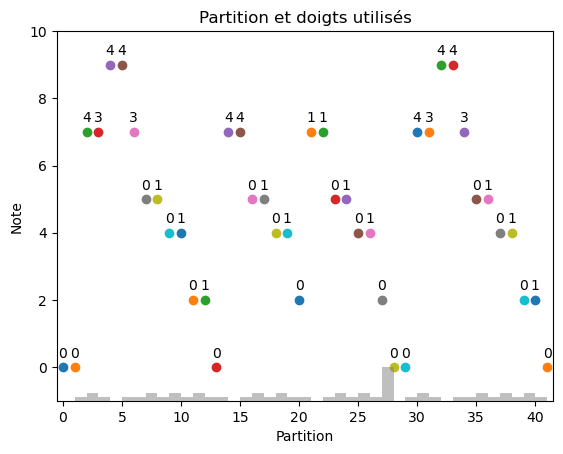

In [11]:

def localSearch(partition):
    solution = glouton(partition)

    for i in range(1, len(partition)-1):
        current_cost = costs[partition[i-1], solution[i-1], partition[i], solution[i]]
        current_cost += costs[partition[i], solution[i], partition[i+1], solution[i+1]]
        
        for d in range(D):
            if d == solution[i]:
                continue
            
            new_cost = costs[partition[i-1], solution[i-1], partition[i], d]
            new_cost += costs[partition[i], d, partition[i+1], solution[i+1]]
            if new_cost < current_cost:
                solution[i] = d
                current_cost = new_cost

    return solution

solutionLocal = localSearch(partition)
print("Coût Recherche Locale :", getTotalCost(costs, partition, solutionLocal))
visualize_solution(costs, partition, solutionLocal)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

*Insérer votre réponse ici*
>Soit $n$, la longueur de la mélodie et $D$, le nombre de doigts utilisés où $D=5$ selon l'énoncé du problème.<br>

>Effectuons l'analyse asymptotique de l'algorithme de recherche locale étape par étape :
>1. Tout d'abord, on fait appel à l'algorithme glouton pour initialiser notre solution initiale `solution`. Cette étape se fait en $\Theta(n)$. 
>2. La boucle principale itère de $1$ à $n-2$, pour un total de $n-2$ itérations (qu'on va approximer à $n$ itérations). Pour chaque note i, on calcul le coût de transition autour de cette note. Ces opérations d'accès et d'additions se font en $\Theta(1)$. <br>
Puis, pour chaque doigt (`for d in range(D)`), on évalue quelle est la meilleure transition via des opérations arithmétiques, d'accès, d'assignation et de comparaison en $\Theta(1)$. <br>
En résumé, la boucle externe se fait en $\Theta(n)$ et la boucle interne en $\Theta(D)$ pour une complexité de $\Theta(Dn)$.

> En additionnant les différentes parties de l'algorithme de recherche locale, nous obtenons $\Theta(n+Dn)$.<br>
En utilisant, la règle du maximum et sachant que $D$ est une constante, on peut conclure que le temps d'exécution est de $T(n)\in\Theta(n)$.  

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [12]:
measures_local = measure_procedure(localSearch, dataset, costs)
display_measures_table(measures_local)

Taille           Temps moyen      Score moyen     
1000             7.6              9200.6          
6000             38.0             57200.4         
11000            71.6             103908.8        
16000            103.6            150940.6        
21000            141.8            197169.4        
26000            187.6            244385.2        
31000            222.6            290992.0        
36000            259.0            337632.8        
41000            297.4            385308.4        
46000            333.6            429380.2        
51000            367.2            477470.6        
56000            402.0            527347.2        
61000            440.2            568372.8        
66000            467.4            619667.4        
71000            517.8            669994.0        
76000            542.6            714074.4        
81000            581.0            759648.2        
86000            615.0            804920.4        
91000            655.6         

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

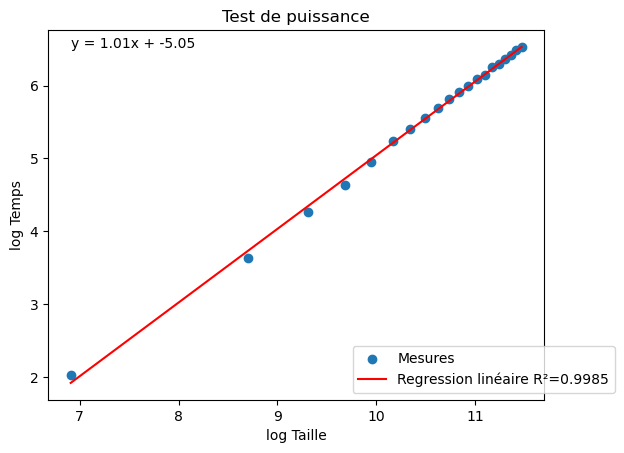

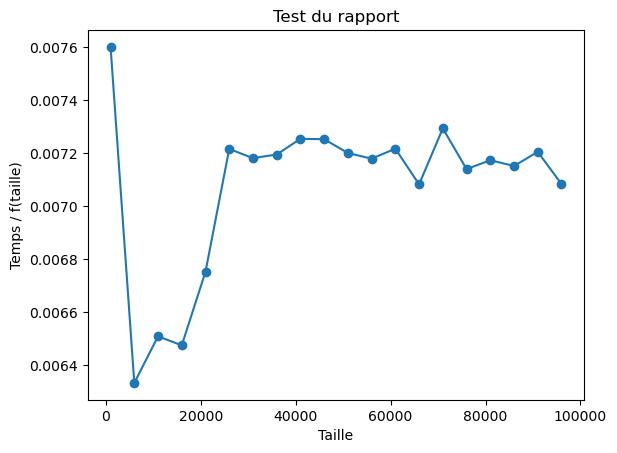

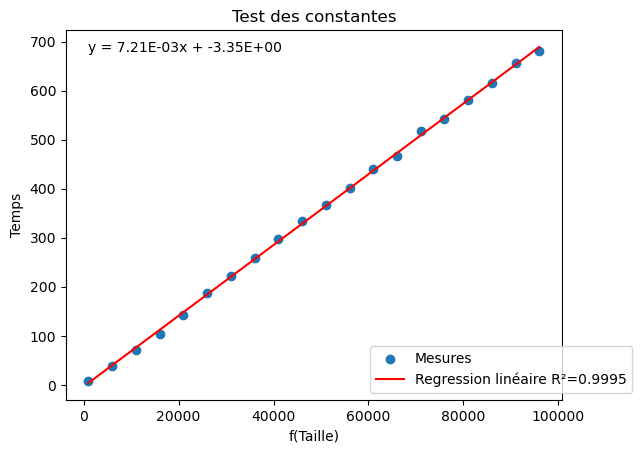

In [13]:
def f(x):
    return x

display_test_puissance(values_test_puissance(measures_local))
display_test_rapport(values_test_rapport(measures_local, f))
display_test_constantes(values_test_constantes(measures_local, f))

*Insérer votre réponse ici*
> Soit $n$, la taille des exemplaires testés.<br>
L'hypothèse de départ obtenue via l'analyse asymptotique est la suivante : $T(n) \in \Theta(n)$. <br>
Les tests utilisés pour confirmer et/ou précisier l'hypothèse sont : le test de puissance, le test du rapport et le test des constantes.

> Soit $x$ : la taille d'un exemplaire et $y$ : le temps d'exécution de l'algorithme.<br><br>
> **1. <u>Test de puissance</u>**<br>
> - En observant le graphe 1, nous remarquons que les points s'alignent tous sur la droite de régression. Le coefficient de détermination $R^2 = 0.9985$, extrêmement proche de 1, indique une corrélation linéaire quasi-parfaite entre $log(x)$ et $log(y)$.
> - La présence d'une corrélation linéaire indique un taux de croissance polynomial dont le degré est donné par la pente ($1.01 \approx 1$). Ainsi, le taux de croissance de l'algorithme de recherche locale est en $\Theta(n)$. Le test de puissance correspond à l'hypothèse de départ : $T(n)\in\Theta(n)$.

> **2. <u>Test du rapport</u>**<br>
> - L'hypothèse que nous souhaitons vérifier avec le test du rapport est $f(x)=x$.<br>
> - Observations du graphe 2 : 
>   - On note une plus grande fluctuation pour les 5 premiers exemplaires (dont la taille varie entre 1000 et 21000 notes). La valeur de la constante oscille entre 0.0062 et 0.0076. Puis, au fur et à mesure que la taille augmente, les oscillations se font moins grandes pour varier entre 0.0071 et 0.0073. Bien que la courbe ne soit pas 100% stable, on peut tout de même constater qu'il y a convergence autour d'une constante différente de 0 et dont on estime "à l'oeil" la valeur moyenne de 0.0072.
>   - Comme la courbe converge vers une constante $b>0$ alors notre hypothèse est validée et b est la constante multiplicative de $f(x)$.
> - Donc, la fonction pour le taux de croissance serait $f(x) = 0.0072x$ et le temps d'exécution de l'algorithme $T(n) \in \Theta(n)$.<br>

> **3. <u>Test des constantes</u>**<br> 
> - L'hypothèse de départ reste inchangée. Pour $T(n)\in\Theta(n)$, nous posons la fonction $f(x)=x$.<br> 
> - En observant le graphe 3, nous constatons que la majorité des points s'alignent avec la droite de régression. La présence d'une corrélation linéaire entre les variables est confirmé par un coefficient de corrélation de 0.9995 (très forte corrélation).<br>
> - Comme il y a corrélation, nous pouvons supposer que :
>   - La pente de la droite ($0.00721$) correspond à la valeur moyenne de la constante multiplicative.<br>
>   - L'ordonnée à l'origine ($-3.35$) correspond au coût fixe.    

> La fonction aurait la forme $f(x) = 0.00721x - 3.35$.

> **<u>Conclusion</u>**<br>
En conclusion, voici ce que nous apprennent ces 3 tests :
> - La complexité du temps d'exécution de l'algorithme de programmation est linéaire : $T(n)\in\Theta(n)$.
> - Dans le test du rapport, nous avons estimé la constante multiplicative pour la fonction représentant le taux de croissance à 0.0072 : $f(x) = 0.0072x$. Le test des constantes vient renforcer cette hypothèse avec une constante multiplicative de 0.00721 (ce qui concorde avec ce qu'on avait trouvé précédemment).

# Évaluation de la consommation énergétique (1 point)

Dans le cadre de ce TP, nous voulons vous sensibiliser à la consommation énergétique de vos algorithmes. Pour ce faire, nous vous fournissons une librairie que vous pouvez utiliser pour évaluer l'énergie nécessaire à la complétion de votre algorithme (https://mlco2.github.io/codecarbon/). Appelez chacun de vos algorithmes ci-bas avec les mêmes exemplaires et comparez le résultat obtenu par chacun.

In [ ]:
%pip install codecarbon

In [23]:
#Commande pour installer la librairie
#!pip install codecarbon

from codecarbon import EmissionsTracker
max_size = max(dataset, key=dataset.get)
max_size_sample = dataset[max_size][0]
try:
    tracker = EmissionsTracker(measure_power_secs=5, tracking_mode="process")

    tracker.start_task("glouton")
    # TODO Appel glouton
    glouton(max_size_sample)
    tracker.stop_task()

    tracker.start_task("dynamic")
    # TODO Appel dynamique
    progDyn(max_size_sample)
    tracker.stop_task()

    tracker.start_task("recherche")
    # TODO Appel recherche
    localSearch(max_size_sample)
    tracker.stop_task()
finally:
    _ = tracker.stop()

[codecarbon WARNING @ 01:08:45] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 01:08:45] [setup] RAM Tracking...
[codecarbon INFO @ 01:08:45] [setup] CPU Tracking...
[codecarbon WARNING @ 01:08:47] We saw that you have a Intel(R) Core(TM) Ultra 9 185H but we don't know it. Please contact us.
[codecarbon WARNING @ 01:08:47] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 01:08:47] CPU Model on constant consumption mode: Intel(R) Core(TM) Ultra 9 185H
[codecarbon WARNING @ 01:08:47] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 01:08:47] [setup] GPU Tracking...
[codecarbon INFO @ 01:08:47] No GPU found.
[codecarbon INFO @ 01:08:47] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
 

Les résultats de l'exécution du code ci-haut devraient apparaître dans un fichier csv. Commentez les résultats obtenus. Vous pouvez trouver une explication de la sortie dans la documentation qui est présente au lien ci-haut.

*Insérer votre réponse ici*

>Un exemplaire de taille $n=96000$ a été utilisé pour tester la consommation énergétique des trois algorithmes. <br>
>Les variables d'intérêts suivant ont été retenues pour l'analyse : 
>- <u>Durée</u> : temps total d'exécution en secondes.
>- <u>Émission</u> : quantité de CO₂ émise, exprimée en kg de CO₂ équivalent.
>- <u>Taux d'émission</u> : l'émission divisée par la durée, exprimée en kg CO₂ éq par seconde.
>- <u>Énergie consommée</u> : somme de l'énergie utilisée par le CPU, le GPU et la RAM, exprimée en kWh.
>
>Par souci de lisibilité, les résultats présentés dans le tableau ci-dessous sont arrondis à 3 chiffres significatifs. <br> Voici le résumé des résultats obtenus : 
>
>| Algorithme        | Durée (s) | Émissions (kg CO₂ éq) | Taux d'émissions (kg CO₂ éq/s) | Énergie consommée (kWh) |
>|:------------------|-----------:|-------------------:|----------------------:|------------------------:|
>| Glouton           | 0.052     | 2.24×10⁻⁹          | 4.00×10⁻⁸             | 5.69×10⁻⁷              |
>| Programmation dynamique         | 0.199     | 1.10×10⁻⁸          | 5.58×10⁻⁸             | 2.80×10⁻⁶              |
>| Recherche locale  | 0.063     | 3.31×10⁻⁹          | 5.23×10⁻⁸             | 8.42×10⁻⁷              |
>  
>- En termes de durée d'exécution, l'algo glouton est le plus rapide (0.052 s) alors que l'algo de programmation dynamique est le plus lent (0.199 s).
>- En termes d'émission de CO₂, l'algo de programmation dynamique est celle qui émet le plus de CO₂ (1.10×10⁻⁸) avec un taux d'émission de 5.58×10⁻⁸ kg CO₂ éq / s. Celui qui émet le moins est le glouton.
>- En ce qui concerne l'énergie totale consommée, l'algo de programmation dynamique est la plus énergivore (2.80×10⁻⁶) alors que le glouton est le plus économe (5.69×10⁻⁷).
>
>Ces observations nous suggèrent un lien direct entre le temps d'exécution (et par extension la complexité algorithmique) et les émissions de CO₂ et la consommation énergétique. Plus un algorithme est >complexe et long à exécuter, plus il consomme d'énergie et émet des émissions. Cela nous sensibilise à l'importance de l'optimisation au niveau des algorithmes. 

# Conclusion et synthèse (2 points)

Résumez succintement vos résultats et analyses, en mettant en évidences les forces et faiblesses de chacun des algorithmes. Indiquez sous quelles conditions vous utiliseriez chacun d'eux.

*Insérer votre réponse ici*

>**Algorithme glouton**
>- <u>Résumé des résultats et analyses</u> : L'analyse asymptotique et les divers tests effectués indiquent un temps d'exécution linéaire : $T(n)\in\Theta(n)$. Il performe le moins bien (coût total = >143).
>- <u>Forces</u> : Simple à concevoir et implanter. Des trois algos, est le plus rapide, le moins énergivore et celui qui émets le moins de CO₂. 
>- <u>Faiblesses</u> : Pas de garanti au niveau de l'optimalité de la solution, peut ne pas retourner de solution alors qu'il y en a une qui existe, la qualité de l'algo dépend de l'heuristique (choix >glouton) 
>- <u>À utiliser sous les conditions suivantes</u> : Pour des échantillons de grandes tailles et lorsqu'on recherche une solution satisfaisante, mais pas nécessairement optimale.
>
>
>**Algorithme de programmation dynamique**
>- <u>Résumé des résultats et analyses</u> : L'analyse asymptotique et les divers tests effectués indiquent un temps d'exécution linéaire : $T(n)\in\Theta(n)$. Il performe le mieux (coût total = 31).
>- <u>Forces</u> : Garanti une solution optimale (si on a une sous-structure optimale)
>- <u>Faiblesses</u> : Utilisation plus importante de la mémoire. Des trois algos, est le plus lent, le plus énergivore et celui qui émets le plus de CO₂. 
>- <u>À utiliser sous les conditions suivantes</u> : Lorsqu'on cherche une solution optimale. Pour des échantillons de moyenne taille.
>
>
>**Algorithme de recherche locale**
>- <u>Résumé des résultats et analyses</u> : L'analyse asymptotique et les divers tests effectués indiquent un temps d'exécution linéaire : $T(n)\in\Theta(n)$. Il performe mieux que le glouton (coût >total = 55).
>- <u>Forces</u> : Solution de meilleure qualité que le glouton, se classe en deuxième en ce qui concerne la rapidité d'exécution, la consommation énergétique et les émissions de CO₂.
>- <u>Faiblesses</u> : Ne garanti pas l'optimalité de la solution, car peut rester bloqué dans un minimum local.
>- <u>À utiliser sous les conditions suivantes</u> : Peut être utilisé pour améliorer un algo glouton (comme ce qui a été fait dans le tp, en implémentant la solution glouton comme solution initiale de >la recherche locale).